Exercise 1

1. Load the CIFAR-10 dataset

2. Implement a CNN model (e.g. 5 conv layers) with <=100 features on output

3. Train the discriminator using triplet loss

4. Save the weights of trained discriminator model

5. Build a model for classification of CIFAR-10, starting with the layers from discriminator and one or two fully-connected layers after that

6. Train this model in the following scenarios and compare results:

a. Randomly initialized model

b. Model with weights for convolutional layers loaded from trained discriminator, fully-connected layers initialized randomly

c. Model with weights for convolutional layers loaded from trained discriminator and freezed, fully-connected layers initialized randomly

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [12]:
train_dataset , test_dataset = cifar10.load_data()

In [3]:
x_train.shape

(50000, 32, 32, 3)

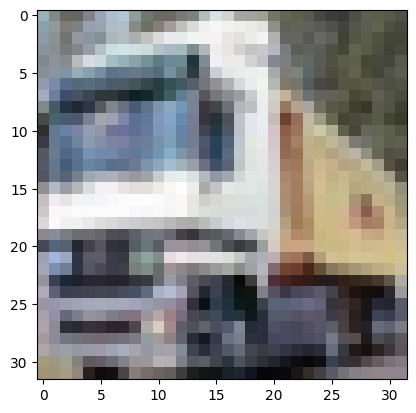

In [4]:
plt.imshow(x_train[1])

C:\Users\akopa\AppData\Local\Temp\ipykernel_24960\1710894633.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


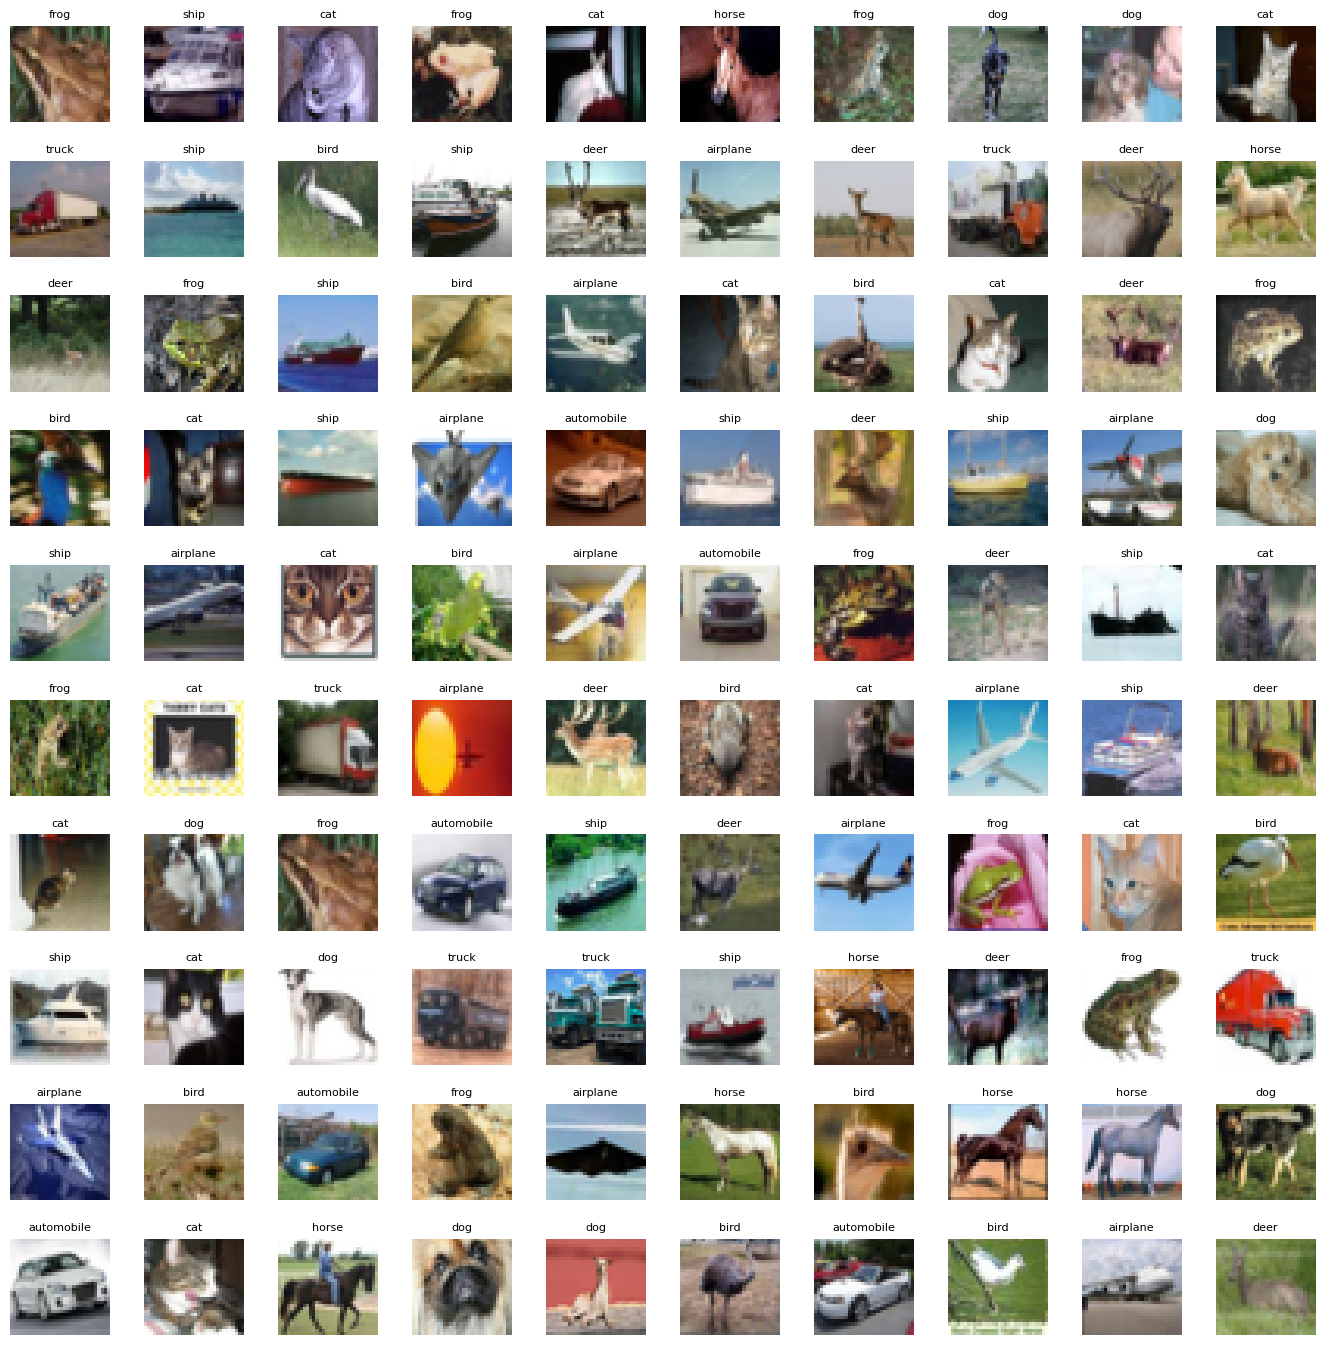

In [5]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
from torch.nn import TripletMarginLoss

some preprocessing

In [8]:
y_train, y_test = y_train.flatten(), y_test.flatten()
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
discriminator  = Sequential([
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10)
])

In [19]:
from typing import Optional, Union, Callable
def triplet_semihard_loss(
    y_true,
    y_pred,
    margin = 1.0,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with semi-hard negative mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=2.4142137>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)

    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss


NameError: name 'TensorLike' is not defined